580 Final Project

In [1]:
# Import the necessary libraries
# This code runs with a specific 'uw' (underwater) environment

import os
from os import path 
import numpy as np
import matplotlib.pyplot as plt

Initialize ORCA Model

In [2]:
# Where the seabed database is
env_file_path = '/mnt/underwater/dallin-harwood/code/orca-examples/data/svp_34sb_hw110m_iso1500_noratio'

# Which water column data to use
# This includes sound speed profile (isovelocity 1500 m/s) and total depth (110 m) of the water
ssp_file = '/mnt/underwater/dallin-harwood/code/Physics-580/Final_Project/ssp_iso1500_hw_110m.csv' 
ocean_depth = ssp_file[77:-5] # pull out just depth from ssp file name

# Which version of the model to use (I have always used whatever these settings are)
opt_file = '/mnt/underwater/dr-neilsen/codes/orca-python/orcalib/data/orca_opt.toml'
 
# Import the model
import orcalib
orca = orcalib.orca.ORCA(base_svp='/mnt/underwater/dallin-harwood/code/orca-examples/data/svp_vgs_general.toml')

# Which seabed to use (this is constant throughout the project)
env_file = 'svp_sand_35m.toml' # 35 m layer of sand on ocean floor
env_name = env_file[:-5]

# Initialize the model
# Force it to use defined ssp instead of whatever is defaulted in env_file
orca = orcalib.orca.ORCA(base_svp=path.join(env_file_path,env_file), base_opt = opt_file)
ssps = orcalib.ssps.SSP(ssp_file)
for ssp in ssps: 
    orca.replace_water_profile(ssp['ssp_array'], constant_rho=ssp['rho'], constant_ap=ssp['alpha'])

Variable in Receiver Depth

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.86it/s]


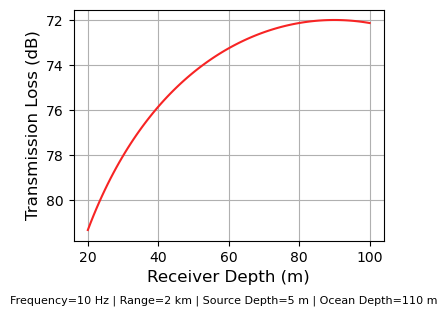

In [ ]:
# Define parameters
freqs = [10] # frequency 
ranges = [2000] # horizontal distance from source to receiver (m)
source_depth = [5] # how far source is below ocean surface (m) 
rec_depth = np.linspace(20, 100, 100) # how far receiver is below ocean surface

# Calculate the transmission loss (TL) from ORCA
tl, gf = np.abs(orcalib.tl.calc_tl_from_orca(orca, freqs, ranges, source_depth, rec_depth, return_gf=True))

# For the case of only one source depth and one receiver depth, remove those singleton dimensions
tl = np.squeeze(tl)

# Plot the results
plt.figure(figsize=(4,3))
plt.plot(rec_depth, tl, color="#F72424") 
plt.xlabel('Receiver Depth (m)', fontsize=12)
plt.ylabel('Transmission Loss (dB)', fontsize=12)
#plt.title(f'TL using {env_name}')
plt.figtext(0.5, -0.1,
            f"Frequency={freqs[0]} Hz | Range={int(ranges[0]/1000)} km | Source Depth={source_depth[0]} m | Ocean Depth={ocean_depth} m", 
            ha="center", fontsize=8)
plt.grid(True)
plt.gca().invert_yaxis()
# I last-minute decided to flip all my graphs. This makes higher values 
# of tl appear lower on the graph, corresponding to lower measured levels. 
plt.show()

Variable in Source Depth

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 105.60it/s]


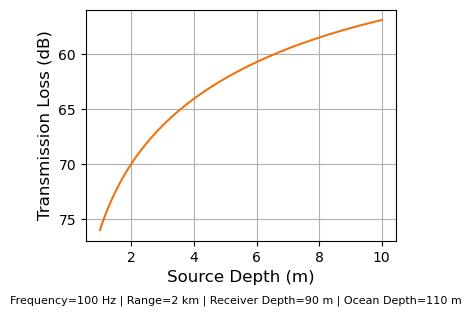

In [ ]:
# Define parameters
freqs = [100] # frequency 
ranges = [2000] # horizontal distance from source to receiver (m)
source_depth = np.linspace(1, 10, 100) # how far source is below ocean surface (m) 
rec_depth = [90] # how far receiver is below ocean surface

# Calculate the transmission loss (TL) from ORCA
tl, gf = np.abs(orcalib.tl.calc_tl_from_orca(orca, freqs, ranges, source_depth, rec_depth, return_gf=True))

# For the case of only one source depth and one receiver depth, remove those singleton dimensions
tl = np.squeeze(tl)

# Plot the results
plt.figure(figsize=(4,3))
plt.plot(source_depth, tl, color="#ED7411")    
plt.xlabel('Source Depth (m)', fontsize=12)
plt.ylabel('Transmission Loss (dB)', fontsize=12)
plt.figtext(0.5, -0.1,
            f"Frequency={freqs[0]} Hz | Range={int(ranges[0]/1000)} km | Receiver Depth={rec_depth[0]} m | Ocean Depth={ocean_depth} m", 
            ha="center", fontsize=8)
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

Variable in Range

Is it correct that minimum range = 100.0 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 114.88it/s]


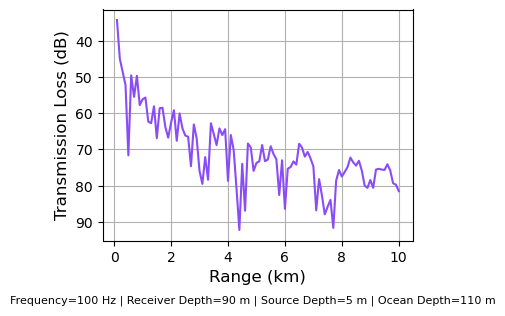

In [ ]:
# Define parameters

freqs = [100] # frequency 
ranges = np.linspace(100, 10000, 100) # horizontal distance from source to receiver (m)
source_depth = [5] # how far source is below ocean surface (m) 
rec_depth = [90] # how far receiver is below ocean surface

# Calculate the transmission loss (TL) from ORCA
tl, gf = np.abs(orcalib.tl.calc_tl_from_orca(orca, freqs, ranges, source_depth, rec_depth, return_gf=True))

# For the case of only one source depth and one receiver depth, remove those singleton dimensions
tl = np.squeeze(tl)

# Plot the results
plt.figure(figsize=(4,3))
plt.plot(ranges/1000, tl, color="#8A4CF6")    
plt.xlabel('Range (km)', fontsize=12)
plt.ylabel('Transmission Loss (dB)', fontsize=12)
#plt.title(f'TL using {env_name}')
plt.figtext(0.5, -0.1,
            f"Frequency={freqs[0]} Hz | Receiver Depth={rec_depth[0]} m | Source Depth={source_depth[0]} m | Ocean Depth={ocean_depth} m", 
            ha="center", fontsize=8)
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

Simplified Model of TL vs Range

Best thetas: [ 5.39425688e+01 -2.16470705e+05  2.42701316e+01  1.20000318e+01]


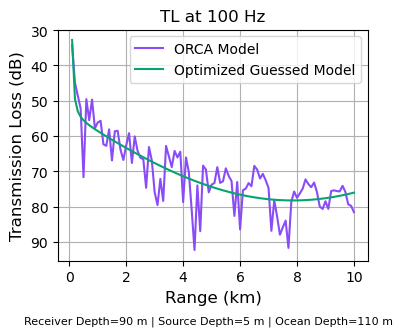

In [ ]:
# Sound attenuation goes as one over distance squared, so try a model with that and
# maybe a sine function to capture the oscillating quality of the transmission loss

# Define the above-mentioned model
def model(theta, range):
    dB_loss = theta[0] + theta[1]*1/(range**2) + theta[2]*np.sin(2*np.pi*theta[3]*range) # not sure what the sine is doing. It fits worse without it
    return dB_loss

# define error as the difference between the model and what ORCA calculated in the above block
def error(theta, range, tl):
  Sol = model(theta, range)
  Err = Sol - tl # works better here not using L2 norm
  return Err

import scipy as sp

theta_guess = [50, 200, 25, 12] # hard to make an intuitive guess. Based on some guess and check

# use scipy.optimize to get best parameters
results_dict = sp.optimize.least_squares(error, theta_guess, args=(ranges, tl))
best_thetas = results_dict['x']
print(f'Best thetas: {best_thetas}')
prediction = model(best_thetas, ranges)

# Plot the results
plt.figure(figsize=(4,3))
plt.plot(ranges/1000, tl, label='ORCA Model', color="#8A4CF6")
plt.plot(ranges/1000, prediction, label='Optimized Guessed Model', color="#07A470")    
plt.xlabel('Range (km)', fontsize=12)
plt.ylabel('Transmission Loss (dB)', fontsize=12)
plt.title(f'TL at {freqs[0]} Hz')
plt.legend()
plt.figtext(0.5, -0.1,
            f"Receiver Depth={rec_depth[0]} m | Source Depth={source_depth[0]} m | Ocean Depth={ocean_depth} m", 
            ha="center", fontsize=8)
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

Variable in Ocean Depth

In [ ]:
# Define parameters
freqs = [100] # frequency 
ranges = [2000] # horizontal distance from source to receiver (m)
source_depth = [5] # how far source is below ocean surface (m) 
rec_depth = [40] # how far receiver is below ocean surface
water_depth = np.linspace(0, 100, 101) + 50 # make an ocean depth from 50 m to 150 m

ocean_depth_tl = []

# Initialize the model
# Force it to use defined ssp instead of whatever is defaulted in env_file
orca = orcalib.orca.ORCA(base_svp=path.join(env_file_path,env_file), base_opt = opt_file)
ssps = orcalib.ssps.SSP(ssp_file)
for ssp in ssps: 
    
    for ii in range(0, len(water_depth)): # calculate TL for each ocean depth
        ssp['ssp_array'][-1][0] = water_depth[ii] # switch out depth in file for the one I want
        orca.replace_water_profile(ssp['ssp_array'], constant_rho=ssp['rho'], constant_ap=ssp['alpha'])

        # Calculate the transmission loss (TL) from ORCA
        tl = np.abs(orcalib.tl.calc_tl_from_orca(orca, freqs, ranges, source_depth, rec_depth, return_gf=False))
        ocean_depth_tl.append(tl)

# For the case of only one source depth and one receiver depth, remove those singleton dimensions
ocean_depth_tl = np.squeeze(ocean_depth_tl)

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 126.02it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 188.63it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.91it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 104.01it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 179.34it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 136.90it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 181.23it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 172.65it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|############################################| 1/1 [00:00<00:00, 80.24it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 144.13it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 177.68it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 177.98it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 107.41it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 163.43it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 166.46it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 163.90it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 171.75it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.46it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.26it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.99it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.09it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 176.13it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.83it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 140.97it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 107.57it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 166.73it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 170.12it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 116.83it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 143.50it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 176.63it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|############################################| 1/1 [00:00<00:00, 80.06it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.24it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 165.53it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 165.43it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 173.43it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 175.83it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.83it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 166.88it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.46it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 142.42it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 113.85it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 168.87it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 167.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 140.99it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 164.86it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 141.90it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|############################################| 1/1 [00:00<00:00, 80.89it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 143.64it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 133.21it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 131.77it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.81it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|############################################| 1/1 [00:00<00:00, 74.02it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 130.27it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.97it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 166.28it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.71it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|############################################| 1/1 [00:00<00:00, 74.32it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 146.85it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.81it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 162.04it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 172.43it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.41it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.63it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|############################################| 1/1 [00:00<00:00, 78.86it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 136.76it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 136.23it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.26it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.78it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|############################################| 1/1 [00:00<00:00, 78.26it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 133.18it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.83it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 165.96it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|############################################| 1/1 [00:00<00:00, 71.43it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 140.79it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 143.82it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 138.83it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.80it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 141.39it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 144.64it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 123.24it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 134.67it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 125.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 130.05it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 124.42it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.00it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 134.83it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 144.87it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 148.75it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.03it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.51it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 148.29it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.96it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.54it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.58it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|############################################| 1/1 [00:00<00:00, 77.64it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 145.44it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.48it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 172.54it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|############################################| 1/1 [00:00<00:00, 76.88it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 134.34it/s]


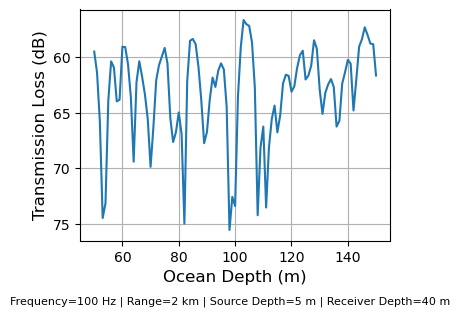

In [ ]:
# Plot the variable ocean depth results
plt.figure(figsize=(4,3))
plt.plot(water_depth, ocean_depth_tl)    
plt.xlabel('Ocean Depth (m)', fontsize=12)
plt.ylabel('Transmission Loss (dB)', fontsize=12)
plt.figtext(0.5, -0.1,
            f"Frequency={freqs[0]} Hz | Range={int(ranges[0]/1000)} km | Source Depth={source_depth[0]} m | Receiver Depth={rec_depth[0]} m", 
            ha="center", fontsize=8)
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

Range vs Frequency

Is it correct that minimum range = 100.0 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress:   0%|                                                 | 0/2481 [00:00<?, ?it/s]

Mode Calc. Progress: 100%|#####################################| 2481/2481 [00:08<00:00, 306.73it/s]


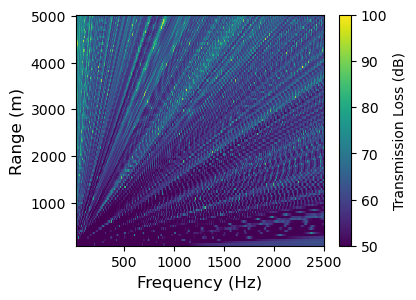

In [ ]:
# Variable Range with Frequency Array

# Define parameters
freqs = np.arange(20,2501,1) # frequency 
ranges = np.linspace(100, 5000, 100) # horizontal distance from source to receiver (m)
source_depth = [5] # how far source is below ocean surface (m) 
rec_depth = [90] # how far receiver is below ocean surface

# Calculate the transmission loss (TL) from ORCA
tl = np.abs(orcalib.tl.calc_tl_from_orca(orca, freqs, ranges, source_depth, rec_depth, return_gf=False))
tl = np.squeeze(tl)

# Plot the results
plt.figure(figsize=(4,3))
plt.pcolormesh(freqs, ranges, tl)    
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Range (m)', fontsize=12)
cbar = plt.colorbar()
cbar.set_label("Transmission Loss (dB)")
plt.clim(50, 100)
plt.show()

Cost Contour

In [ ]:
# Source Depth vs Receiver Depth

# Define parameters
freqs = [100] # frequency 
ranges = [2000] # horizontal distance from source to receiver (m)
source_depth = np.linspace(5, 40, 30) # how far source is below ocean surface (m) 
rec_depth = np.linspace(45, 105, 30) # how far receiver is below ocean surface

# Create a "true" TL value to calculate cost
true_source_depth = [25]
true_rec_depth = [80]
orca = orcalib.orca.ORCA(base_svp=path.join(env_file_path,env_file), base_opt = opt_file)
true_tl = np.abs(orcalib.tl.calc_tl_from_orca(orca, freqs, ranges, true_source_depth, true_rec_depth, return_gf=False))
true_tl = np.squeeze(true_tl)

# Create cost plot
SRC, REC = np.meshgrid(source_depth, rec_depth)
Cost = np.zeros_like(SRC)

for ii in range(0,len(source_depth)):
    for jj in range(0,len(rec_depth)):
        tl = abs(orcalib.tl.calc_tl_from_orca(orca, freqs, ranges, SRC[ii,jj], REC[ii,jj], return_gf=False))
        tl = np.squeeze(tl)
        Cost[ii,jj] = tl - true_tl
        # Cost[ii,jj] = np.linalg.norm(tl - true_tl, 2)**2 # don't really need L2 norm here because there is only one value

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 128.65it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.25it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.08it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.06it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.83it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.61it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.85it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.58it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.56it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.92it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.63it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.99it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.57it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.82it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.26it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.76it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 109.11it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.19it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.46it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.49it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.95it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.21it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.88it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.90it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.10it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.56it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.71it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.11it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.63it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.88it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.39it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.90it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.80it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.76it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.70it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.86it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.83it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.60it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.09it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.93it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.07it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.97it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.80it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.50it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.75it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.29it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.28it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.41it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.17it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.14it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.19it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.85it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.81it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.21it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.55it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.58it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.92it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.43it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.14it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.68it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.41it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.65it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.51it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 131.85it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.06it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.80it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.99it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.90it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.62it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.78it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.09it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.62it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.16it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.00it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.92it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.77it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.57it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 162.29it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.31it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.82it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.92it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.47it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.22it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.57it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.09it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.44it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.35it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.35it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.94it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.08it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.97it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.01it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.41it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.70it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.48it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.27it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.75it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.56it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.41it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.50it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.36it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.71it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.86it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.77it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.69it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.18it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.98it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.21it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.89it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.80it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.93it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.70it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.40it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.01it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.79it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.49it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.91it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.51it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.56it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.14it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 148.88it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.98it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.48it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.54it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.91it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 147.24it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.19it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.10it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.41it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.07it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.86it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.53it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.78it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.98it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 111.67it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.97it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 141.47it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 141.21it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.15it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 135.45it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.79it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 124.26it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.42it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 145.18it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 143.26it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 128.98it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.06it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.96it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 102.40it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 119.47it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.39it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.58it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 145.95it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 122.69it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.83it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.06it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.73it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.46it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.43it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.85it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.73it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.67it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.91it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.53it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.10it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.33it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.23it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.94it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.53it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.54it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.37it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.98it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.06it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.93it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.28it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.89it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.59it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.21it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.72it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.02it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.59it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.14it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.18it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.98it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.09it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.15it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.12it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.70it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.84it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.68it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.91it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.52it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.00it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.84it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.29it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.44it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.79it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.14it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.55it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.47it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.34it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.10it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.37it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.37it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.75it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.32it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.15it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.61it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.77it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.59it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.09it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.27it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.72it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.93it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.28it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.66it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.86it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.79it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.95it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.57it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.42it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.35it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.64it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.81it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.90it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.55it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.50it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.98it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.20it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.13it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.12it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.98it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.53it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.95it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.72it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.28it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.34it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.59it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.13it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.76it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.69it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.71it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.41it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.10it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.42it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.34it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.51it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.44it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.53it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.14it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.79it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.61it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.10it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.19it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.84it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.94it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.84it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.00it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.47it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.45it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.66it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.95it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.08it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.57it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.73it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.35it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.98it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.86it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 147.85it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.15it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.98it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.13it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.59it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.41it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.21it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.14it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.63it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.59it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.20it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.42it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.53it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.50it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.01it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.70it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.35it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.80it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.09it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.39it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.03it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.32it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.62it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.47it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.19it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.61it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.78it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 147.88it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.00it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.88it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|############################################| 1/1 [00:00<00:00, 29.28it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 118.44it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.75it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.37it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.97it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.05it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.64it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.10it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.08it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.87it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.33it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.70it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.08it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.68it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.07it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.56it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.12it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.13it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.07it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.00it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.11it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.92it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.54it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.51it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.44it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.11it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.57it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.00it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.63it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.56it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.17it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.11it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.63it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.13it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.11it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.72it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.80it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.64it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.01it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.86it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.71it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.37it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.43it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.12it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.33it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.00it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.12it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.75it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.77it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.11it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.81it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.73it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.14it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.23it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.92it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.97it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.92it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.45it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.70it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.65it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.41it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.65it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.78it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.92it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.97it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.23it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.95it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.01it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.57it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 143.76it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.80it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.10it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.86it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.27it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.05it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.58it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.44it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.74it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.01it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.76it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.80it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.97it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.49it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.14it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.07it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.02it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 145.19it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.00it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.63it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.98it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.47it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.98it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.02it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.94it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.40it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.79it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.79it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.41it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.29it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.41it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.67it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.32it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.60it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.36it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.81it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.20it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.98it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.62it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.74it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.78it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.81it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.69it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.11it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.19it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.44it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.06it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.59it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.89it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.42it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.84it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.13it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.55it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.97it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.83it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.37it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.09it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.11it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.31it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.82it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.22it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.79it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.90it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.74it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.99it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.69it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.55it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.22it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.00it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.74it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.79it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.29it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.25it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.83it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.79it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.28it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.89it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.52it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.62it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.39it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.63it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.68it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.94it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.32it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.28it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.69it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.67it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.22it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.66it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.94it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|############################################| 1/1 [00:00<00:00, 76.43it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.54it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.43it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.26it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.53it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.23it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.58it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.77it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.75it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.50it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.37it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.17it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.42it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.36it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.51it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.71it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.92it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.25it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.33it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.03it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.73it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.32it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.59it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.08it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.01it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.39it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.96it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.67it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.06it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.34it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.79it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.27it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.95it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.82it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.33it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.67it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.65it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.58it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.79it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.69it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.78it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.03it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.29it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.58it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.35it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.49it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.57it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.88it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.74it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.74it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.68it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.60it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.94it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.20it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.51it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.14it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.93it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.75it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.26it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.81it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.91it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.99it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.12it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.00it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.61it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.49it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.03it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.80it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.90it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.32it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.46it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.79it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.25it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.14it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.45it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.53it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.78it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.44it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.92it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.88it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.87it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.26it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.77it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.60it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.73it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.34it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.29it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.29it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.66it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.95it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.35it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.70it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.08it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.78it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.15it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.77it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 148.11it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.05it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.76it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.28it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.51it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.19it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.40it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.82it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.50it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.76it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.76it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.92it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.39it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.65it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.78it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.17it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.45it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.49it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.21it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.81it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.83it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.83it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.75it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.53it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.41it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.45it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.60it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.82it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.82it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.36it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.49it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.04it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.90it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.40it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.78it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.26it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.05it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.91it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.33it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.72it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.94it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.98it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.97it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.85it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.11it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.65it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.93it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.74it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.15it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.03it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.83it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.08it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.78it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.92it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.11it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.74it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.89it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.27it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.99it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.61it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.85it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 117.54it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.31it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 165.25it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.97it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.05it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.92it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.04it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.97it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.86it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.13it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.32it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.18it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.37it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.32it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.01it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.73it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.40it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.39it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.33it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.37it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.48it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 148.26it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.82it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.78it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.27it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.27it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.68it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.18it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.20it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.49it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.94it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.63it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.65it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.33it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.27it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.50it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.60it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.99it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.23it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.97it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.40it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.68it/s]

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca



Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.80it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.70it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.70it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.59it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.33it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.29it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 162.97it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.78it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.07it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.50it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.79it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.28it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.83it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.91it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.90it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.31it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.70it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.00it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.71it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.33it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.60it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 149.06it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.51it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 162.90it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.06it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.75it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.13it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.40it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.34it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.17it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.94it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.25it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.19it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.85it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.34it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.92it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.36it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.82it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.56it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.56it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.26it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.61it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.91it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.95it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.39it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.44it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.75it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 153.49it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.49it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.62it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.10it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.60it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.85it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.33it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.32it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.81it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.81it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.86it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.54it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.01it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.22it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.77it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.85it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.59it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.18it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.25it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.63it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.85it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.93it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.12it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.26it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.54it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.75it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.27it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.89it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.72it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.54it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 163.16it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.25it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.69it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.41it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.76it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.37it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.08it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.23it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.65it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 163.44it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.36it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.88it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.31it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.84it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.35it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.56it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.15it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.13it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.35it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.63it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.27it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.81it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.54it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 147.42it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.85it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.42it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.25it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.73it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.90it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.93it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.13it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.84it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.40it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.84it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.06it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.94it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.73it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.33it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.08it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.89it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.84it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.04it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|############################################| 1/1 [00:00<00:00, 73.61it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 117.48it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 163.78it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 163.25it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 162.52it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 164.31it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.49it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.92it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.42it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.14it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.44it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.81it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.71it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.29it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.97it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.73it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.41it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.56it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.64it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.28it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.74it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.26it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.08it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.79it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.14it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.66it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.12it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.50it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 147.97it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.84it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.82it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.10it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.16it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.51it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.47it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.39it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.00it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.57it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.48it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.20it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.33it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.46it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 151.32it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.32it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.30it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.77it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.63it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.35it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.39it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.19it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.84it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 154.87it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.16it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.40it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.98it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.24it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.54it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.82it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.25it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.14it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.83it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.19it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 150.36it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.39it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.84it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.82it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.40it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.91it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.28it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.28it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.41it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.11it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.91it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 152.78it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.38it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.85it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.80it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.34it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 160.47it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.10it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.27it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 132.68it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 163.49it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 155.56it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.46it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 161.70it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.93it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 159.74it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.14it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 157.33it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 158.75it/s]


Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|###########################################| 1/1 [00:00<00:00, 156.15it/s]


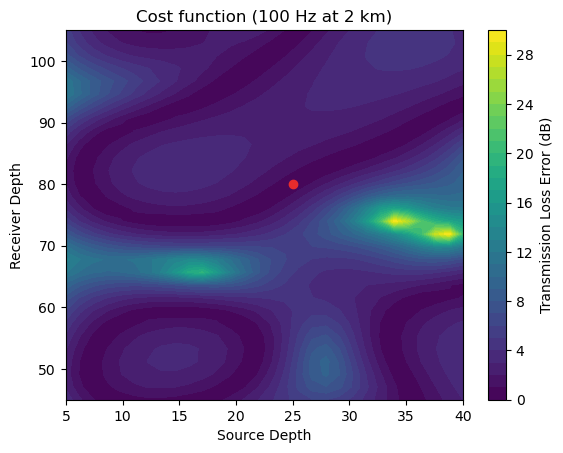

In [ ]:
# Plot contour lines
plt.contourf(SRC, REC, abs(Cost), levels=30, cmap='viridis')
plt.title(f"Cost function ({freqs[0]} Hz at {int(ranges[0]/1000)} km)")
plt.xlabel('Source Depth')
plt.ylabel('Receiver Depth')
cbar = plt.colorbar()
cbar.set_label("Transmission Loss Error (dB)")
plt.scatter(true_source_depth[0],true_rec_depth[0],color="#E82C2C") # true value data point
plt.show()

In [ ]:
# Redo contour but without constant frequency

# Define parameters
freqs = np.arange(100,501,1) # frequency 
ranges = [2000] # horizontal distance from source to receiver (m)
source_depth = np.linspace(5, 40, 20) # how far source is below ocean surface (m) 
rec_depth = np.linspace(45, 105, 20) # how far receiver is below ocean surface

# Create a "true" TL value to calculate cost
true_source_depth = [25]
true_rec_depth = [80]
orca = orcalib.orca.ORCA(base_svp=path.join(env_file_path,env_file), base_opt = opt_file)
true_tl = np.abs(orcalib.tl.calc_tl_from_orca(orca, freqs, ranges, true_source_depth, true_rec_depth, return_gf=False)) # now an array of 400 elements
true_tl = np.squeeze(true_tl)

# Create cost plot
SRC, REC = np.meshgrid(source_depth, rec_depth)
Cost = np.zeros_like(SRC)

for ii in range(0,len(source_depth)):
    for jj in range(0,len(rec_depth)):
        print(ii) # see how far along it is
        tl = abs(orcalib.tl.calc_tl_from_orca(orca, freqs, ranges, SRC[ii,jj], REC[ii,jj], return_gf=False))
        tl = np.squeeze(tl)
        Cost[ii,jj] = np.linalg.norm(tl - true_tl, 2)**2 # implement the L2 norm

Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 195.33it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.91it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.83it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.50it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.35it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 194.32it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.45it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 207.36it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 210.34it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 203.30it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 205.18it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.64it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.38it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.18it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.83it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.61it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.36it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.52it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.49it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.53it/s]


0
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 214.71it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 214.12it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.76it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 209.72it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 207.34it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 204.56it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.64it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.85it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.39it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.67it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.78it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.34it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 214.50it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.10it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.69it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.22it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.93it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.84it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 210.79it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.14it/s]


1
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 200.55it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 183.26it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 196.22it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.44it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.15it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.15it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.17it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.42it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.43it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 195.29it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.14it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 191.24it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 177.22it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 192.47it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.12it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.16it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.00it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.02it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.87it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.24it/s]


2
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.84it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.88it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.12it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.17it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.17it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.14it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.34it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.59it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.51it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.18it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.77it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 203.86it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 206.29it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 204.00it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 192.21it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.41it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.35it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.18it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 195.47it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 197.96it/s]


3
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.18it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 197.50it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 195.81it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 197.31it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.37it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 194.42it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 195.75it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.63it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.48it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.92it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.15it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.46it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.24it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.30it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.97it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.40it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 193.29it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 188.67it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 171.81it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 177.68it/s]


4
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 155.23it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 151.74it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 155.78it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 163.64it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 160.28it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:03<00:00, 110.68it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 164.24it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 163.19it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 155.10it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:03<00:00, 114.38it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:03<00:00, 112.33it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:03<00:00, 111.43it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:03<00:00, 113.73it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:03<00:00, 112.84it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:03<00:00, 114.33it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 149.21it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:03<00:00, 112.04it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:03<00:00, 114.28it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 174.23it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 168.55it/s]


5
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 177.58it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 160.35it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:03<00:00, 115.36it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 156.23it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 196.93it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.19it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.01it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.76it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.28it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.03it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 191.60it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.57it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.51it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 209.66it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 209.37it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 209.60it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 209.61it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 209.17it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 209.47it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 208.06it/s]


6
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 209.04it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.03it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.50it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 207.91it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.29it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.11it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.57it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.10it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.68it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.96it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.30it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.76it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.42it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 207.44it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.39it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 210.61it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.36it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.68it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 209.87it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 209.69it/s]


7
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.79it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.28it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 206.65it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.72it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 197.92it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 188.09it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 206.80it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 210.93it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 195.97it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 197.80it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 210.50it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 208.76it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 204.71it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 204.90it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 205.09it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.58it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.32it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 203.37it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 204.79it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 205.19it/s]


8
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.34it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 203.43it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.79it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 204.58it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.49it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.34it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.15it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.26it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.95it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 200.73it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.18it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 194.86it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 197.49it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.32it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 204.09it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 205.16it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 204.65it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 203.51it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 206.13it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 203.44it/s]


9
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.62it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.35it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 206.61it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 217.21it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 203.54it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.42it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.73it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 214.56it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 210.90it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.90it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.46it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.72it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.75it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 196.08it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 196.07it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.39it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.34it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 197.00it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 196.18it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 187.81it/s]


10
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 189.40it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 176.44it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 195.20it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.09it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.71it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.47it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 200.70it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 195.48it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.01it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.11it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.25it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 195.58it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 181.82it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 189.87it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 190.32it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 188.53it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 191.16it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 191.16it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 193.68it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 190.65it/s]


11
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 189.24it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 187.18it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 185.67it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 178.43it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 182.38it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 186.80it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 189.53it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 192.54it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 193.53it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 190.48it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 194.65it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 196.91it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.96it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 203.10it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 203.62it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 204.23it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 204.83it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 204.85it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.02it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.82it/s]


12
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 204.32it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 203.79it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 206.38it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 205.78it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 205.45it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 204.58it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 205.41it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 205.23it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 205.58it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 205.35it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 204.93it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 205.19it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 195.32it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 193.88it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.28it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.18it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.84it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.06it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.64it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.89it/s]


13
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 196.92it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 197.76it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.11it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.14it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.05it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.71it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.13it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.39it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.36it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.51it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.20it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.47it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.04it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.37it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 197.65it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.61it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.90it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 191.27it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 190.91it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 196.87it/s]


14
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 194.43it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.59it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 203.03it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.65it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.78it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.47it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.97it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.36it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.46it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 167.58it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 184.57it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.57it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.47it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.49it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.41it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.74it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.18it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.69it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.76it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.51it/s]


15
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 200.90it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.74it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.34it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.56it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.13it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 200.66it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 202.85it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 199.31it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 198.35it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 200.24it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 200.74it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 201.26it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.53it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.40it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 215.06it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 216.43it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 215.37it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 215.39it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 216.30it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 183.50it/s]


16
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 192.89it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 216.73it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 215.75it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.85it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.70it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 214.70it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 215.14it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 215.26it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 214.51it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 216.33it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 216.08it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 214.12it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.94it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 208.51it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.51it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 215.18it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 205.30it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 207.12it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 205.09it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 208.73it/s]


17
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 205.97it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 209.94it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 216.52it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 214.02it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 205.39it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 203.02it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 210.90it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.87it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.96it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.86it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 194.79it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:02<00:00, 191.93it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 209.00it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 208.61it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 206.50it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 210.48it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.27it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.11it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.58it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.13it/s]


18
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 213.22it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.96it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.44it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.86it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.13it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.15it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.76it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.83it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.88it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.86it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.28it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.34it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 211.75it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 207.54it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 214.44it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.98it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 207.84it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 209.85it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.85it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 212.60it/s]


19
Is it correct that minimum range = 2000 meters??  If not, please change to meters before calculating tl from orca


Mode Calc. Progress: 100%|#######################################| 401/401 [00:01<00:00, 209.99it/s]


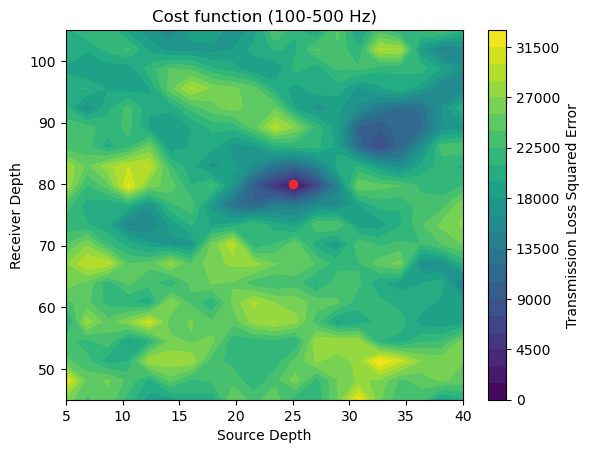

In [ ]:
# Plot contour lines
plt.contourf(SRC, REC, Cost, levels=30, cmap='viridis')
plt.title(f"Cost function ({np.min(freqs)}-{np.max(freqs)} Hz)")
plt.xlabel('Source Depth')
plt.ylabel('Receiver Depth')
cbar = plt.colorbar()
cbar.set_label("Transmission Loss Squared Error")
plt.scatter(true_source_depth[0],true_rec_depth[0],color="#E82C2C") # same true value dot
plt.show()